Image: Kather_texture_2016_image_tiles_5000/02_STROMA/10D03_CRC-Prim-HE-03.tif_Row_1_Col_301.tif
Predicted: 02_STROMA (Index: 1, Confidence: 0.9999)
Actual: 02_STROMA (Index: 1)
Correct: True



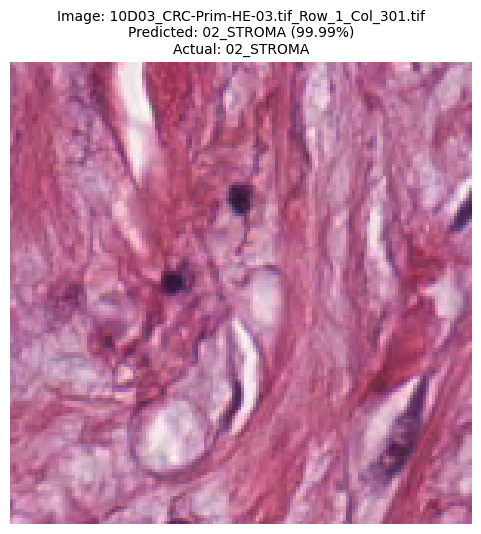

In [2]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd

# --- Constants ---
MODEL_PATH = 'resnet_results/best_resnet50_model.pth'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = (224, 224)
DATA_DIR = 'Kather_texture_2016_image_tiles_5000'
CSV_FILE = None  # Optional: 'dataset_splits/test_split.csv'

# Classes must match training setup
CLASSES = {
    0: '01_TUMOR',
    1: '02_STROMA',
    2: '03_COMPLEX',
    3: '04_LYMPHO',
    4: '05_DEBRIS',
    5: '06_MUCOSA',
    6: '07_ADIPOSE',
    7: '08_EMPTY'
}
NUM_CLASSES = len(CLASSES)

# --- Validation/Test Transforms ---
val_test_transforms = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# --- Load Model ---
def load_model(model_path):
    model = models.resnet50(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

# --- Image Preprocessing ---
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = val_test_transforms(image=image)
    image_tensor = transformed["image"].unsqueeze(0)  # Add batch dimension
    return image_tensor, image

# --- Predict Class ---
def predict_image(model, image_tensor):
    with torch.no_grad():
        image_tensor = image_tensor.to(DEVICE)
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class_idx].item()
    return CLASSES[predicted_class_idx], confidence, predicted_class_idx

# --- Get Real Label (from CSV or folder) ---
def get_real_label(image_path, csv_file=None):
    if csv_file:
        df = pd.read_csv(csv_file)
        row = df[df['image_path'] == image_path]
        if not row.empty:
            label_idx = row.iloc[0]['label']
            return CLASSES[label_idx], label_idx
        else:
            raise ValueError(f"Image path {image_path} not found in CSV.")
    else:
        folder_name = os.path.basename(os.path.dirname(image_path))
        for idx, class_name in CLASSES.items():
            if class_name == folder_name:
                return class_name, idx
        raise ValueError(f"Could not determine label for {image_path} (folder: {folder_name})")

# --- Display Prediction ---
def display_image(image, predicted_class, predicted_prob, real_class, image_path):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Image: {os.path.basename(image_path)}\n"
              f"Predicted: {predicted_class} ({predicted_prob:.2%})\n"
              f"Actual: {real_class}", fontsize=10)
    plt.axis('off')
    plt.show()

# --- Main Function ---
def main(image_path, csv_file=None):
    model = load_model(MODEL_PATH)
    image_tensor, original_image = preprocess_image(image_path)
    pred_class, prob, pred_idx = predict_image(model, image_tensor)
    real_class, real_idx = get_real_label(image_path, csv_file)
    
    print(f"Image: {image_path}")
    print(f"Predicted: {pred_class} (Index: {pred_idx}, Confidence: {prob:.4f})")
    print(f"Actual: {real_class} (Index: {real_idx})")
    print(f"Correct: {pred_class == real_class}\n")
    
    display_image(original_image, pred_class, prob, real_class, image_path)

# --- Example usage ---
if __name__ == "__main__":
    sample_image = "Kather_texture_2016_image_tiles_5000/02_STROMA/10D03_CRC-Prim-HE-03.tif_Row_1_Col_301.tif"
    try:
        main(sample_image, CSV_FILE)
    except Exception as e:
        print(f"Error: {e}")
